### Exercises Week 3 

In [1]:
# %% imports
# libraries
import torch
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob
import os
import numpy as np

# local imports
import Fast_MRI_dataloader
# import autoencoder_template
from matplotlib import pyplot as plt
from Fast_MRI_dataloader import create_dataloaders

# set-up folders
data_loc = os.getcwd()
print(data_loc)
data_loc = data_loc + '\Fast_MRI_Knee'
batch_size = 16
train_loader, val_loader = create_dataloaders(data_loc, batch_size)

C:\Users\20167271\Desktop\ML for signal processing\5LSL0-GIT\Assignment 4


In [2]:
def acc_img(X):
    '''
    Given the partial k_space image X, calculate the accelerated measurement image:

    Arguments:
    ----------------
    X: torch.tensor()

    returns:
    --------------
    Y: torch.tensor()
    '''
    Y = torch.fft.ifft2(torch.fft.ifftshift(X))
    return Y

## Exercise 5 - ConvNet
As a starting point for a deep learning solution, design an end-to-end convolutional neural
network. As input it should take an initial reconstruction from a partial k-space measurement
and output a guess for the final reconstruction. The net is not (yet) allowed to make
use of knowledge about the sampling mask.

(a) [1pt] What loss function would be most suitable to train this network, and what
underlying assumption have you made by choosing this loss function?

KL divergence is a metric to compare the distribution of pixel values between the input and output images. The MSE loss can be suitable as well but we already know that there is loss of spatial information given the mask and we do not want to penalize shifts or blurring, we want the network to reconstruct the original scan as similarly as possible with the input. Since the network does not know the mask, it should penalize the difference in distributions rather than shift in image. We assume the input distribution is symmetric.

(b) [3pt] Design a convolutional neural network of no more than 4 layers. Train it for at
least 10 epochs and plot both the training loss and testing

In [3]:
########################### BAD MODEL ################################
class KReconstruct(nn.Module):
    def __init__(self):
        super(KReconstruct, self).__init__()
        self.model = nn.Sequential(
            #nn.Conv2d(2, 4, kernel_size=12, stride=2, padding=0,dilation=1),  # 155x155
            #nn.BatchNorm2d(4),
            #nn.ReLU(),

            #nn.Conv2d(4, 16, kernel_size=7, stride=1, padding=0, dilation=2), # 143x143
            #nn.BatchNorm2d(16),
            #nn.ReLU(),

            #nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=0, dilation=1), # 139x139
            #nn.BatchNorm2d(32),
            #nn.ReLU(),

            #nn.ConvTranspose2d(32, 1, kernel_size=23, stride=2, padding=1, dilation=2, output_padding=1) # 320x320
            
            nn.Conv2d(2,4, kernel_size=7, stride=1, dilation=2),  
            nn.BatchNorm2d(4),
            nn.ReLU(),
            
            nn.Conv2d(4,8, kernel_size=5, stride=1, dilation=2),  
            nn.BatchNorm2d(8),
            nn.ReLU(),
            
            nn.Conv2d(8,16, kernel_size=3, stride=1, dilation=1),  
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.ConvTranspose2d(16, 1, kernel_size=13, stride=1, padding=1, dilation=2, output_padding=0)
        )

    def forward(self, x):
        xreal = torch.real(x)
        ximag = torch.imag(x)
        x = torch.cat((xreal, ximag), 1)
        
        img = self.model(x)
        #out = nn.functional.log_softmax(img)
        
        return img#, out
    
    def test(self, x):
        xreal = torch.real(x)
        ximag = torch.imag(x)
        x = torch.cat((xreal, ximag), 1)
        
        return self.model(x)


model = KReconstruct()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
#criterion = nn.KLDivLoss()
criterion = nn.MSELoss()


kspace, M, gt = next(iter(test_loader))
m = KReconstruct()
this = m.test(acc_img(kspace).unsqueeze(1))
this.squeeze(1).size()
gt.size()
type(this.squeeze(1))

In [5]:
# Begin training for 10 epochs

epochs=10
# set device
dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('Running on: ', device)
model = model.to(device=device)
# keep track of losses
eval_dic = {'Loss_t': [], 'train_acc': [],'Loss_v': [], 'valid_acc': []}
loss_train = []
loss_val = []
loss_dict = {'train_loss':[], 'val_loss':[]}


print(f"\nTraining is about to start on {device}\n")
for e in range(epochs):
    print(f"\nTraining epoch {e}: \t")
    mia_loss = 0
    for batch_idx,(kspace, M, gt) in enumerate(tqdm(train_loader)):
        # prepare for training
        model.train(True)  
        optimizer.zero_grad()
        # move to gpu if available
        reconstructed_img = acc_img(kspace).to(device=device)
        #M = M.to(device=device)
        gt = gt.to(device=device)
        # forward pass
        out = model(reconstructed_img.unsqueeze(1))
        out = out.squeeze(1)
        # backpropagate loss
        loss = criterion(out, gt)
        loss = loss.to(torch.float16)
        loss.backward()
        mia_loss += loss.item()
        optimizer.step()
        
    # update loss dictionary
    loss_dict['train_loss'].append(mia_loss/(batch_idx+1))

    # print epoch loss
    print(f"\nEpoch training loss is {mia_loss/(batch_idx+1)}")

    with torch.no_grad():  # setting so that no backprop happens during validation
        model.eval()  # setting so that no backprop happens during validation
        vloss = 0
        for (kspace, M, gt) in tqdm(val_loader):
            reconstructed_img = acc_img(kspace).to(device=device)
            #M = M.to(device=device)
            gt = gt.to(device=device)
            out = model(reconstructed_img.unsqueeze(1))
            out = out.squeeze(1)
            vloss += criterion(out, gt).to(torch.float16).item()
        # update loss dictionary  
        loss_dict['val_loss'].append(vloss/len(val_loader))
        # print validation loss
        print(f"\nEpoch validation loss is {vloss/len(val_loader)}")

# save trained model
model_path = os.getcwd() + '\Modelex5.pth'
torch.save(model.state_dict(), model_path)
    

  0%|          | 0/47 [00:00<?, ?it/s]

Running on:  cuda

Training is about to start on cuda


Training epoch 0: 	


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch training loss is 0.1206431287400266


  0%|          | 0/47 [00:00<?, ?it/s]


Epoch validation loss is 0.11617279052734375

Training epoch 1: 	


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch training loss is 0.11212677651263298


  0%|          | 0/47 [00:00<?, ?it/s]


Epoch validation loss is 0.11290740966796875

Training epoch 2: 	


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch training loss is 0.11005158120013298


  0%|          | 0/47 [00:00<?, ?it/s]


Epoch validation loss is 0.10615158081054688

Training epoch 3: 	


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch training loss is 0.10495189910239362


  0%|          | 0/47 [00:00<?, ?it/s]


Epoch validation loss is 0.10492324829101562

Training epoch 4: 	


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch training loss is 0.1059661215924202


  0%|          | 0/47 [00:00<?, ?it/s]


Epoch validation loss is 0.11054611206054688

Training epoch 5: 	


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch training loss is 0.10233128324468085


  0%|          | 0/47 [00:00<?, ?it/s]


Epoch validation loss is 0.10723114013671875

Training epoch 6: 	


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch training loss is 0.10152224276928191


  0%|          | 0/47 [00:00<?, ?it/s]


Epoch validation loss is 0.1031646728515625

Training epoch 7: 	


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch training loss is 0.1004729575299202


  0%|          | 0/47 [00:00<?, ?it/s]


Epoch validation loss is 0.10052871704101562

Training epoch 8: 	


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch training loss is 0.10302474650930851


  0%|          | 0/47 [00:00<?, ?it/s]


Epoch validation loss is 0.10773849487304688

Training epoch 9: 	


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch training loss is 0.10103785738031915


100%|██████████| 16/16 [00:07<00:00,  2.25it/s]


Epoch validation loss is 0.10031509399414062


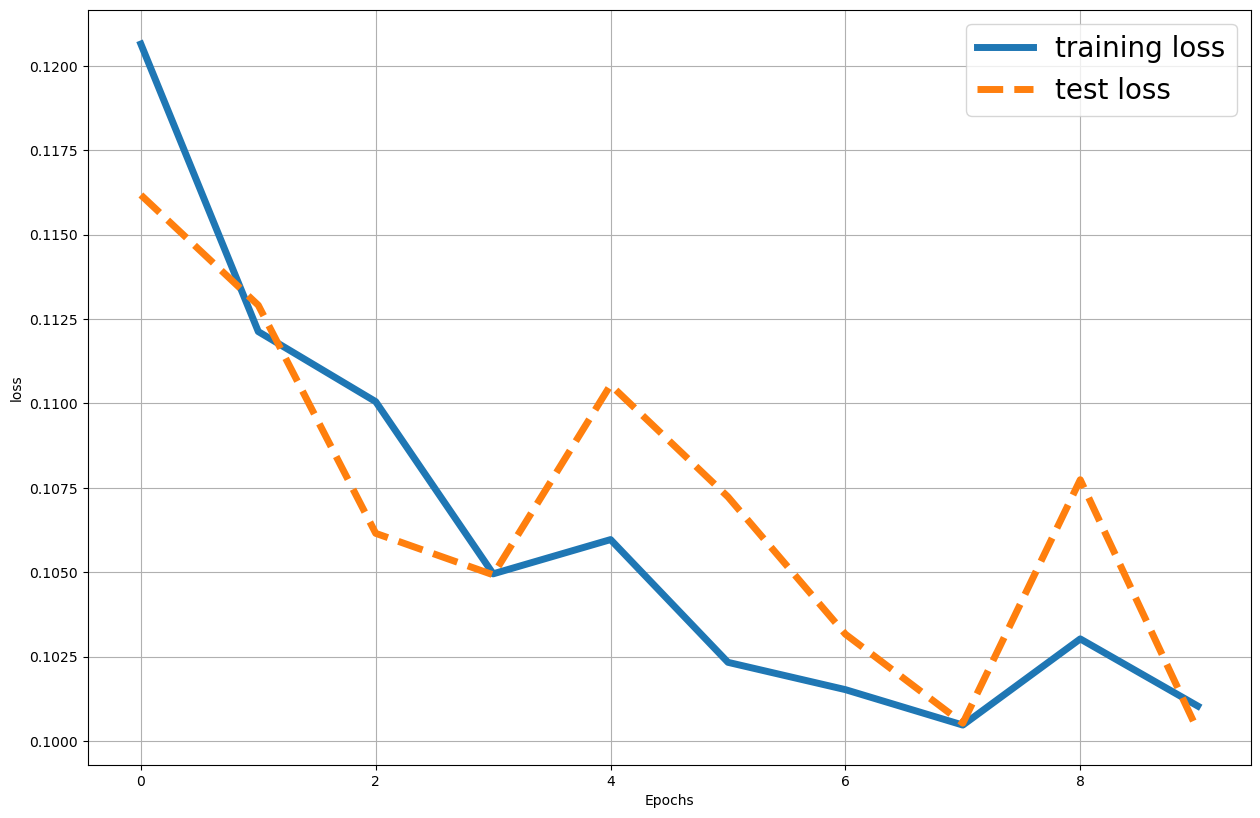

In [6]:
# Plot losses


#validation loss is actually test loss
plt.figure(figsize=(15,10),dpi=100)
plt.plot(range(epochs), loss_dict['train_loss'], 
         label='training loss', linewidth=5)
plt.plot(range(epochs), np.array(loss_dict['val_loss']), 
         label='test loss', linestyle='--', linewidth=5)
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend(loc=0, prop={'size': 20})


(c) [2pt] Repeat exercise 4c using your trained ConvNet.

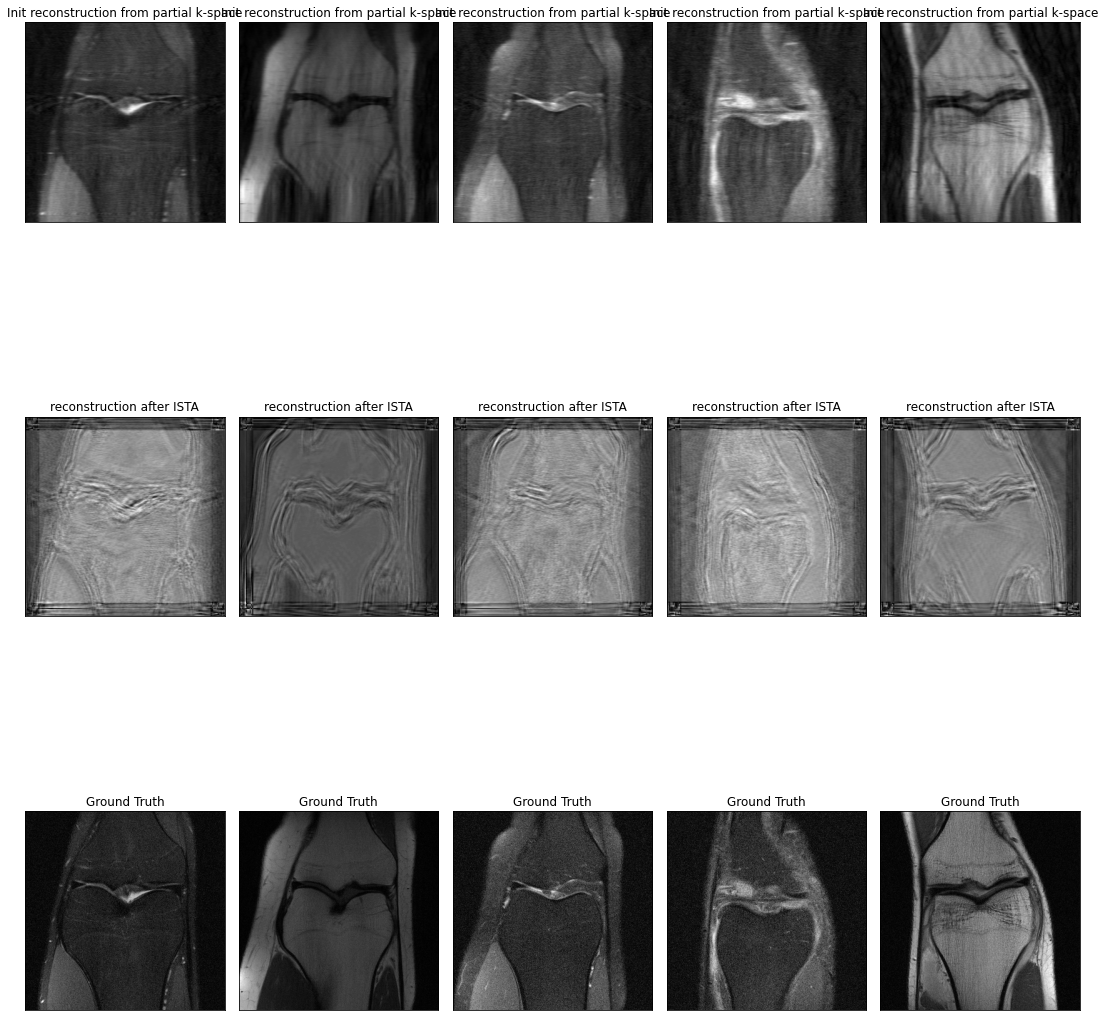

In [10]:
# Load model
model_path = os.getcwd() + '\Modelex5.pth'
model = KReconstruct()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()
model.to('cpu')

kspace,Mask,gt = next(iter(val_loader))
# (mu,shrinkage,K,kspace,mask)
plt.figure(figsize=(15,20))
for i in range(5):

    rec_init_kp =acc_img(kspace[i:i+1,:,:]) # init recon from k-space
    output = model.forward(rec_init_kp.unsqueeze(1)) # recon mri_ista
    gt_MRI = gt[i,:,:]

    

    plt.subplot(3,5,i+1)
    plt.imshow(torch.abs(rec_init_kp.squeeze(0)),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title("Init reconstruction from partial k-space")
    
    plt.subplot(3,5,i+6)
    plt.imshow(torch.abs(output.squeeze(0).squeeze(0).detach()),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title("reconstruction after ISTA")
    
    plt.subplot(3,5,i+11)
    plt.imshow(torch.abs(gt_MRI),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title("Ground Truth")

    plt.tight_layout()

torch.Size([1, 1, 320, 320])